<a href="https://colab.research.google.com/github/Lukec-lehighu/CSE337-Labs/blob/main/lab10_half_cheetah_dynamics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# HalfCheetah: Learn a Dynamics Model from Random Rollouts (Then Validate It)

**Goal:** In this notebook you'll (1) collect random experience tuples \((s_t, a_t, r_t, s_{t+1})\) from `HalfCheetah-v4`, (2) train a neural network to predict **state deltas** \(\Delta s = s_{t+1}-s_t\), and (3) **validate** the model with one-step and multi-step (open-loop) rollouts.

This mirrors the first phase of model-based control (e.g., MPPI): learn a model offline, then use it for planning.



## 0. Requirements

- Python 3.9+
- PyTorch `>= 1.10`
- Gymnasium `>= 0.29`
- MuJoCo with `HalfCheetah-v4` (install `mujoco` and `gymnasium[mujoco]`)

```bash
pip install "gymnasium[mujoco]" mujoco torch matplotlib
```

**Try and understand what RunningNormalizer does.**


In [1]:

import os, math, random, time
from dataclasses import dataclass
from typing import Tuple
import numpy as np
import torch as th
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import gymnasium as gym

def to_t(x):
    return th.as_tensor(x, dtype=th.float32)

def fanin_init(m):
    if isinstance(m, nn.Linear):
        bound = 1.0 / math.sqrt(m.weight.size(1))
        nn.init.uniform_(m.weight, -bound, +bound)
        nn.init.zeros_(m.bias)

class RunningNormalizer:
    """Feature-wise running mean/std (Welford)."""
    def __init__(self, dim, eps=1e-8):
        self.dim = dim
        self.count = 0
        self.mean = np.zeros(dim, dtype=np.float64)
        self.M2   = np.zeros(dim, dtype=np.float64)
        self.eps  = eps

    def update(self, x: np.ndarray):
        x = np.asarray(x)
        if x.ndim == 1: x = x[None, :]
        for v in x:
            self.count += 1
            d = v - self.mean
            self.mean += d / self.count
            d2 = v - self.mean
            self.M2 += d * d2

    @property
    def var(self):
        if self.count < 2: return np.ones(self.dim, dtype=np.float64)
        return self.M2 / (self.count - 1 + 1e-12)

    @property
    def std(self):
        return np.sqrt(self.var + self.eps)

    def normalize(self, x): return (x - self.mean) / self.std
    def denormalize(self, x): return x * self.std + self.mean

def set_seed(seed=42):
    random.seed(seed); np.random.seed(seed); th.manual_seed(seed)



## Initializing Environment and Figure Out Observation Structure

`HalfCheetah-v4` exposes observations as `[qpos[1:], qvel[:]]`. The forward velocity is `qvel[0]`, which sits at index `len(qpos[1:])` inside the observation vector. We'll extract that index for later validation/plots. :::: This is important for planning, if we want to know what each state represents


In [2]:

set_seed(42)
env = gym.make("HalfCheetah-v4")
obs_dim = env.observation_space.shape[0]
act_dim = env.action_space.shape[0]
act_low = env.action_space.low
act_high = env.action_space.high

# Find start index of qvel inside obs = [qpos[1:], qvel[:]]
nq = env.unwrapped.model.nq
qvel_start = int(nq - 1)
print("obs_dim:", obs_dim, "act_dim:", act_dim, "qvel_start:", qvel_start)


obs_dim: 17 act_dim: 6 qvel_start: 8


C:\Users\lukec\miniconda3\lib\site-packages\gymnasium\envs\registration.py:519: DeprecationWarning: WARN: The environment HalfCheetah-v4 is out of date. You should consider upgrading to version `v5`.
  logger.deprecation(


## 🧩 Task 1: Prepare the Replay Buffer
**Goal:** Store transitions \((s_t, a_t, s_{t+1})\) and return training pairs \((x, y) = (s_t, a_t, s_{t+1} - s_t)\).

**Instructions:**
- Implement `add()` to record transitions.
- Add a `sample()` method to randomly sample batch of certain size.



In [26]:
# Create the class and create a class object
class Replay:
  def __init__(self, obs_dim, act_dim, capacity=300000):
    self.obs = np.zeros((capacity, obs_dim), dtype=np.float32)
    self.act = np.zeros((capacity, act_dim), dtype=np.float32)
    self.nxt = np.zeros((capacity, obs_dim), dtype=np.float32)
    self.rew = np.zeros((capacity, 1), dtype=np.float32)
    self.term = np.zeros((capacity, 1), dtype=np.float32)
    self.ptr = 0; self.size = 0; self.cap = capacity

  def add(self, s, a, r, sp, term):
    if self.size >= self.cap:
      return

    p = self.ptr
    if type(s) == tuple:
      return

    self.obs[p] = s
    self.act[p] = a
    self.nxt[p] = sp
    self.rew[p] = r
    self.term[p] = term

    self.ptr += 1
    self.size += 1

  def sample(self, batch):
    s = self.size
    combined = [(self.obs[i], self.act[i], self.rew[i], self.nxt[i]-self.obs[i]) for i in range(s)]
    return random.sample(combined, min(batch, s))

replay = Replay(obs_dim, act_dim)



## Task 2. Collect Random Rollouts

- Gather random actions for a number of steps to create our training dataset. Collect data for 100000 steps.
- Call the function and fill the replay buffer


In [27]:
def collect_random(env, replay, steps=10000, seed=42):
  state = env.reset()[0]
  for step in range(steps):
    a = np.random.uniform(act_low, act_high, act_dim)
    next_state, r, term, trunc, _ = env.step(a)
    replay.add(state, a, r, next_state, term)

    state = next_state

    if term or trunc:
        state = env.reset()

collect_random(env, replay)


## Task 3. Update normalizers from the collected random data in the replay buffer

We normalize inputs (`[s,a]`) and targets (`Δs = s' - s`) for stable training.


In [28]:
obs_norm = RunningNormalizer(obs_dim)
inp_norm = RunningNormalizer(obs_dim + act_dim)
targ_norm = RunningNormalizer(obs_dim)

# write the function to update the normalizers from the data collected in the buffer
def update_normalizers_from_buffer(replay):
    obs_norm.update(replay.obs)
    inp_norm.update(np.append(replay.obs, replay.act, axis=1))
    targ_norm.update(replay.nxt - replay.obs)

update_normalizers_from_buffer(replay)
print("Normalizers ready.")


Normalizers ready.



## Defining the Neural Dynamics Model

We predict **normalized** `Δs` from **normalized** `[s, a]`.
NN parameters:

- initialize a deterministic NN with a ExponentialLR sceduler( that decays the learning rate with epoch)
- width = 200, depth = 3, lr = 1e-3, weight_decay - 1e-5, gamma for scheduler = 0.8
- These are a starting point but not the best parameters.


In [29]:
class DetMLP(nn.Module):
    """Predicts Δstate deterministically."""
    def __init__(self, in_dim, out_dim, width=200, depth=3):
        super().__init__()
        layers = []
        last = in_dim
        for _ in range(depth):
            layers += [nn.Linear(last, width), nn.ReLU()]
            last = width
        layers += [nn.Linear(last, out_dim)]
        self.net = nn.Sequential(*layers)
        self.apply(fanin_init)

    def forward(self, x):
        return self.net(x)

device = th.device("cuda" if th.cuda.is_available() else "cpu")

in_dim = obs_dim + act_dim
out_dim = obs_dim
model = DetMLP(in_dim, out_dim, width=200, depth=3).to(device)
opt = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
mse = nn.MSELoss()
scheduler = optim.lr_scheduler.ExponentialLR(opt, gamma=0.8)



## Task 4. Train the Model

We minimize MSE between predicted normalized `Δs` and target normalized `Δs`.

- Train in batches, keep the batch size 256
- Use a learning rate scheduler that decays the learning rate as training progresses. You may use the pytorch utility. See how the learning rate decays with each epoch.
- Train for 30 epochs and plot the training curve. Loss vs epoch.
- Find the best parameters(defined in the previous block)



100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:03<00:00, 51.81it/s]


AVG LOSS FOR EPOCH 1: 7.870435175223228


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:02<00:00, 53.10it/s]


AVG LOSS FOR EPOCH 2: 3.1304825253975697


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:02<00:00, 52.44it/s]


AVG LOSS FOR EPOCH 3: 2.4836575373625145


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:03<00:00, 50.47it/s]


AVG LOSS FOR EPOCH 4: 2.185426657016461


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:02<00:00, 54.40it/s]


AVG LOSS FOR EPOCH 5: 1.9888835503504827


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:02<00:00, 52.11it/s]


AVG LOSS FOR EPOCH 6: 1.8592130060379322


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:03<00:00, 51.91it/s]


AVG LOSS FOR EPOCH 7: 1.7702255615821252


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:02<00:00, 52.01it/s]


AVG LOSS FOR EPOCH 8: 1.6164048069562666


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:02<00:00, 53.18it/s]


AVG LOSS FOR EPOCH 9: 1.5329688634627905


100%|████████████████████████████████████████████████████████████████████████████████| 156/156 [00:03<00:00, 50.94it/s]


AVG LOSS FOR EPOCH 10: 1.4652228622864454


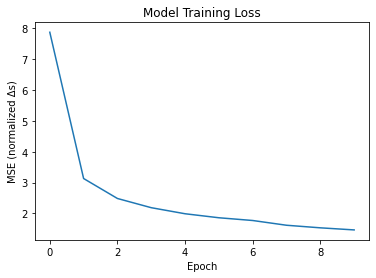

In [30]:
from tqdm import tqdm
def train_model(model, replay, epochs=30, batch_size=256):
  losses = []
  for e in range(epochs):
    temp_loss = []
    for batch in tqdm(range(replay.size // batch_size)):
      batch_data = replay.sample(batch_size)

      # (self.obs[i], self.act[i], self.rew[i], self.nxt[i]-self.obs[i])
      input_data = inp_norm.normalize([np.append(x[0], x[1]) for x in batch_data])
      input_data = th.FloatTensor(input_data).to(device)

      targets = targ_norm.normalize([x[3] for x in batch_data])
      targets = th.FloatTensor(targets).to(device)

      opt.zero_grad()
      outputs = model(input_data)
      loss = mse(outputs, targets)

      loss.backward()
      opt.step()

      temp_loss.append(loss.item())
      #print(f'Loss for Epoch {e+1}, Batch {batch+1}: {loss.item()}')

    #compute and report average loss for epoch
    avg = sum(temp_loss) / len(temp_loss)
    print(f'AVG LOSS FOR EPOCH {e+1}: {avg}')
    losses.append(avg)



  return losses

losses = train_model(model, replay, epochs=10, batch_size=64)
plt.figure()
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("MSE (normalized Δs)")
plt.title("Model Training Loss")
plt.show()


## Task 5. Validate your model: One-Step and Multi-Step Prediction Error

- Evaluate your trained model on a held-out set of random transitions.
Generate a batch of unseen samples, predict the next-state delta, and compute the one-step MSE.

- Repeat with open-loop rollouts of length k.
Drive both the real environment and the model with the same action sequence, then report how prediction error grows across steps.

One-Step MSE: 1.5303850173950195


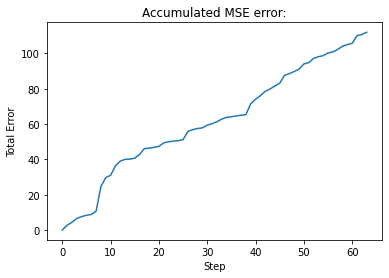

In [31]:
k = 64

val = Replay(obs_dim, act_dim)
collect_random(env, val, steps=k)

batch_data = val.sample(k)

input_data = inp_norm.normalize([np.append(x[0], x[1]) for x in batch_data])
input_data = th.FloatTensor(input_data).to(device)

targets = targ_norm.normalize([x[3] for x in batch_data])
targets = th.FloatTensor(targets).to(device)

opt.zero_grad()
outputs = model(input_data)
loss = mse(outputs, targets)

print(f'One-Step MSE: {loss.item()}')

# open-loop rollouts
errors = []
state = env.reset()[0]
for step in range(k):
  a = np.random.uniform(act_low, act_high, act_dim)
  next_state, r, term, trunc, _ = env.step(a)

  input_data = th.FloatTensor(inp_norm.normalize(np.append(state.copy(), a))).to(device)
  target = th.FloatTensor(targ_norm.normalize(np.array(next_state) - np.array(state))).to(device)

  opt.zero_grad()
  outputs = model(input_data)
  loss = mse(outputs, target)

  errors.append(errors[-1] + loss.item() if len(errors)>0 else loss.item())

  state = next_state
  if term or trunc:
      state = env.reset()

plt.title('Accumulated MSE error:')
plt.xlabel('Step')
plt.ylabel('Total Error')
plt.plot(errors)
plt.show()



## Task 6. Visualize Rollout Trajectories

**Setup**
Call model.eval() so gradients stay off.
Reset the env with the provided seed; keep a copy of the initial observation.


**Choose actions**
Pre-sample k actions from env.action_space.sample() so the real system and the model rollout see the same sequence.

**Roll forward**
For each action:
Step the real env (env.step(a)), append the new observation.
For the model path:
Build [s_model, a], normalize via inp_norm.normalize, turn into a tensor with to_t.
Run the network, de-normalize with targ_norm.denormalize, add to the last model state, append.
Stop early if the env terminates or truncates.

**Plot**
Plot the real trajectory as one line, model trajectory as another.



[-0.03645451  0.1027312 ]


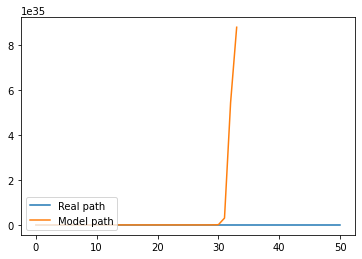

In [32]:
def visualize_rollout(env, model, k=50, dims=(0, 5, 10), seed=2025):
  model.eval()
  state = env.reset(seed=seed)[0]
  model_state = state.copy()

  real_path = [state,]
  model_path = [model_state,]

  actions = [env.action_space.sample() for _ in range(k)]
  for a in actions:
    #real step
    next_state, r, term, trunc, _ = env.step(a)
    state = next_state

    if term or trunc:
      break

    #predicted step
    input_data = th.FloatTensor(inp_norm.normalize(np.append(model_state.copy(), a))).to(device)
    mstep = model(input_data).cpu().detach().numpy()
    model_state = model_state + mstep

    #update arrays
    real_path.append(state)
    model_path.append(model_state)

  print(real_path[1][0:2])
  #only graphing using one value from each state in the trajectory for an easier to view graph
  plt.plot([real_path[i][15] for i in range(len(real_path))], label='Real path')
  plt.plot([model_path[i][15] for i in range(len(model_path))], label='Model path')
  plt.legend(loc='lower left')
  plt.show()

# Uncomment to visualize
dims = list(range(1, 17))
visualize_rollout(env, model, k=50, dims=dims)#(qvel_start, qvel_start+1, qvel_start+2))



## 9. Answer the questions :

1. How good is your model?
- My model only useful for predicting up to 20-30 time steps in the future, which is good enough for some applications.
2. Is this training enough for planning, or do we need continual training?
- This training is enough for planning, as it allow us to look a few time steps in the future to determine which trajectory will result in the highest total reward. We don't need to looks too far in the future, so being able to predict the next closest states is beneficial enough.
3. How is this system different from the mountain car problem? Why can't we learn this in one episode?
- This system is much more complex, with less restraints on how our agent can move. We also don't have access to the dynamics of the system, and the system starts at a random state each time the environment is reset, which makes it so that there isn't a set number of actions that our model can take everytime in order to solve the problem.
4. Why do we use a running normalizer instead of a static normalizer? Think about the nature of the algorithm taught in class.
- We use a running normalizer since the observation space of the model is infinite, so using a static normalizer would make the input values incredibly small and hard for the model to use to build useful gradients. A running normalizer allows for the algorithm to adjust the mean of the dataset as the model explores new values in the observation space. This way, all values likely to be seen by the model will be able to be normalized to usable values.

